# **Bayesian Hierarchical Model for Operational Risk Capital Estimation**

Ming-Sen Wang 2019-11-27

# Design Purposes

The purpose of this notebook is to demonstrate how Bayesian Hierarchical Model is applicable to quantifying operational risk capital.

The data generating process for operational riks has the following notable features:
1. Operational risk covers a wide range of different types of events, each of which has distinct characteristics.
2. Operational losses are idiosyncratic in nature.  Losses of certain event types have heavt tails.
3. There is usually a reporting threshold for reporting losses, which can be considered as removing outliers on the lower tail.

Oftentime, a risk quant is tasked with estimating risk exposures for each different financial instruments or products.  Some of the products may have few historical losses while some products are abundant with historical loss events.

The current best industry practice that estimates risk exposures separately by each product (or risk segment) is essentially throwing away useful information.  There are two most obvious examples.  Firstly, the information contained at the enterprise level is not used for each individual risk segment.  When a risk segment has few historical events, without additional subject matter expertise, its risk profile should be presumed to follow the enterprise risk profile.  Secondly, subject matter experts are usually able to make assessments regarding the occurrence frequency of each idiosyncratic event.  For instance, when a 200 million dollar loss event occurs, risk experts can usually make a good gauge of whether this event can happen in 1 in 20 years or 1 in 50 years based on their experience and intuition.  This information can be incorporated to regulate the posterior distributions with proper use of priors.

# Environment Setup

This is just a quick section to set up the environment executable on Colab and to load libraries.

In [85]:
!pip install arviz

In [0]:
import arviz as az
import pymc3 as pm
from scipy import stats
import math
import numpy as np
import graphviz
import pandas as pd

# Data Generating Process

We assume 5 different products.  The log-losses are generated from Student's t-distribution to simulate heavy-tailed nature of operational risk losses.  We use a large degree of freedom for the first three products such that the losses are approximately normally distributed.  The fourth product has a sole loss event.  The loss of the last product has a heavy tail.

The parameters for each product are designed to test different performance aspects of the models:

1. Almost normally distributed losses with a large truncated proportion
2. Almost normally distributed losses with a small truncated proportion
3. Slightly heavier tailed losses
4. Single loss with location and scale parameters approximately equal to their population counterparts
5. Heavy-tailed losses 

In [0]:
n_product = [1200, 4000, 2000, 1, 120]
mu_true = [9, 12, 13, 11.78, 12]
sigma_true = [2, 1.2, 1, 1.278, 1.2]
nu_true = [20, 20, 5.4, 20, 2.2]

In [0]:
np.random.seed(42)
sim_loss = []
ix = []

for i in range(len(n_product)):
    sim_loss = np.append(sim_loss, np.exp(stats.t.rvs(size = n_product[i], loc = mu_true[i], scale = sigma_true[i], df = nu_true[i])))
    ix = np.append(ix, np.repeat(i, n_product[i]))

ix = ix.astype('int')

In [89]:
np.max(sim_loss)/1e6

498.2895168202959

## Set Truncation Threshold at $5000
There is normally a reporting threshold for operational losses.  Risk quants can only observe loss events above the reporting threshold.

In [0]:
data = sim_loss[sim_loss >= 5000]
group_ix = ix[sim_loss >= 5000]

In [91]:
# number of observed data points in each product
[sum(group_ix == x) for x in np.unique(group_ix)]

[681, 3985, 1994, 1, 115]

In [92]:
# overall proportion truncated
len(data)/len(sim_loss)

0.9255566179483677

In [93]:
# proportion truncated by product
[1 - d/n for d, n in zip([sum(group_ix == x) for x in np.unique(group_ix)], [sum(ix == x) for x in np.unique(ix)])]

[0.4325, 0.003750000000000031, 0.0030000000000000027, 0.0, 0.04166666666666663]

# Modeling Approach

We propose a hierarchical model with common hyper priors across different products.  The model uses a data augmentation step to account for the reporting threshold.  To estimate a censored data model in PyMC3, we first need to know the number of censored data points.  This can be done in an iterative manner.  We can 

1. first estimate the model using some sample statistics as an initial guess 
2. then use the posterior means of the inital model to update the estimated number of censored points
3. use the updated number of censored points to obtain the final estimates

[PyMC3 Censored Data Models](https://docs.pymc.io/notebooks/censored_data.html) has a good tutorial on how to estimate a censored data model with data augmentation.  

We recommend to use Student's T distribution for the log losses because of its performance against the existence of the idiosyncratic events and its easy explanability.

In [0]:
data_mean = np.mean(np.log(data))
data_min = np.min(np.log(data))
data_max = np.max(np.log(data))

## Step 1: Estimate the model with initial guesses

We can begin with the sample average and sample standard deviation of each risk segment as our initial guesses.  For the degree of freedom, we begin with some large integers, which implicitly assumes that the data are "almost" log-normal.

In [0]:
group_mean = [np.mean(np.log(data[group_ix == i])) for i in np.unique(group_ix)]
group_sd = [np.sqrt(np.var(np.log(data[group_ix == i]))) if sum(group_ix == i) > 1 else 0.1 for i in np.unique(group_ix)]

In [0]:
n_group_observed = [sum(group_ix == i) for i in np.unique(group_ix)]
p_censored = [stats.t.cdf(np.log(5000), loc = m, scale = s, df = d) for m, s, d in zip(
    group_mean, 
    group_sd, 
    [20, 20, 20, 20, 20]
)]
n_group_censored = [int(np.ceil(n/(1 - p) * p)) for n, p in zip(n_group_observed, p_censored)]

In [97]:
n_group_censored

[79, 25, 2, 1, 2]

In [0]:
group_data = [data[group_ix == i] for i in np.unique(group_ix)]

The Student's T distribution has three parameters.  We use Exponential distribution as the prior for the degree of freedom, Normal for the location, and Half Normal for the scale.  We use conjugate priors as the hyper priors.

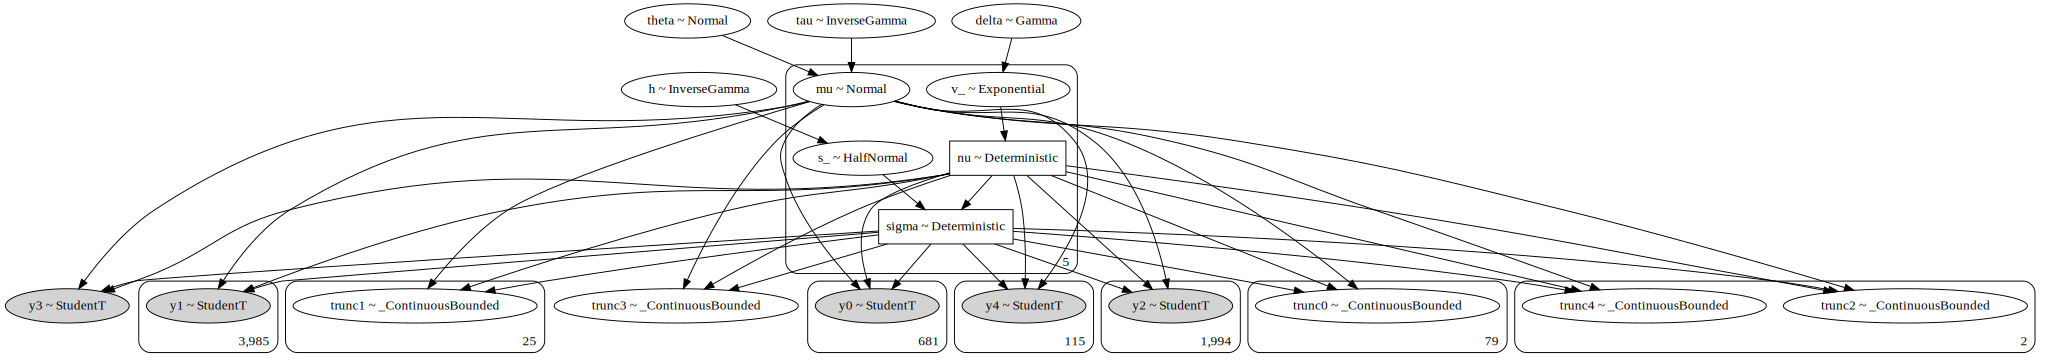

In [99]:
with pm.Model() as hier_model_tt:
    
    # hyper priors
    theta = pm.Normal('theta', mu = data_mean, sd = 10.0)
    tau = pm.InverseGamma('tau', 2.0, 10.0)
    
    h = pm.InverseGamma('h', 2.0, 10.0)   

    delta = pm.Gamma('delta', 2.0, 0.1) 

    # priors
    # degree of freedom
    # shifted exponential
    v_ = pm.Exponential('v_', 1.0/delta, shape = len(np.unique(group_ix)))
    nu = pm.Deterministic('nu', v_ + 1)
    
    #location
    mu = pm.Normal('mu', mu = theta, sd = tau, shape = len(np.unique(group_ix)))
    
    # scale
    s_ = pm.HalfNormal('s_', sd = h, shape = len(np.unique(group_ix)))
    sigma = pm.Deterministic('sigma', s_/nu) # reparametrize scale based on Gelman's recommendation
    
    # likelihood
    for i in np.unique(group_ix):
        trunc = pm.Bound(pm.StudentT, upper = np.log(5000))('trunc%s'%i, mu=mu[i], sigma=sigma[i], nu = nu[i],shape = n_group_censored[i])
        y = pm.StudentT('y%s'%i, mu = mu[i], sigma = sigma[i], nu = nu[i], observed = np.log(group_data[i]), shape = n_group_observed[i])

pm.model_to_graphviz(hier_model_tt)  

In [100]:
with hier_model_tt:
    trace_htt = pm.sample(4000, tune = 2500, cores = 2, chains = 4, random_seed = 42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [trunc4, trunc3, trunc2, trunc1, trunc0, s_, mu, v_, delta, h, tau, theta]
Sampling 4 chains: 100%|██████████| 26000/26000 [23:04<00:00, 18.78draws/s]


In [0]:
res = az.summary(trace_htt, var_names = ['mu', 'sigma', 'nu'])

## Step 2: Update the estimated number of censored points with the posterior means

Once we obtain the parameter estimates, we can use these estimate to calculate the number of censored data points and re-estimate the model.

In [0]:
num_groups = len(np.unique(group_ix))
p_censored = [stats.t.cdf(np.log(5000), loc = m, scale = s, df = d) for m, s, d in zip(
    res['mean'][:num_groups], 
    res['mean'][num_groups:(2 * num_groups)],
    res['mean'][(2 * num_groups):]
)]
n_group_censored = [int(np.ceil(n/(1 - p) * p)) for n, p in zip(n_group_observed, p_censored)]

In [103]:
with pm.Model() as hier_model_tt:
    
    # hyper priors
    theta = pm.Normal('theta', mu = data_mean, sd = 10.0)
    tau = pm.InverseGamma('tau', 2.0, 10.0)
    
    h = pm.InverseGamma('h', 2.0, 10.0)   

    delta = pm.Gamma('delta', 2.0, 0.1) 

    # priors
    # degree of freedom
    # shifted exponential
    v_ = pm.Exponential('v_', 1.0/delta, shape = len(np.unique(group_ix)))
    nu = pm.Deterministic('nu', v_ + 1)
    
    #location
    mu = pm.Normal('mu', mu = theta, sd = tau, shape = len(np.unique(group_ix)))
    
    # scale
    s_ = pm.HalfNormal('s_', sd = h, shape = len(np.unique(group_ix)))
    sigma = pm.Deterministic('sigma', s_/nu) # reparametrize scale based on Gelman's recommendation
    
    # likelihood
    for i in np.unique(group_ix):
        trunc = pm.Bound(pm.StudentT, upper = np.log(5000))('trunc%s'%i, mu=mu[i], sigma=sigma[i], nu = nu[i],shape = n_group_censored[i])
        y = pm.StudentT('y%s'%i, mu = mu[i], sigma = sigma[i], nu = nu[i], observed = np.log(group_data[i]), shape = n_group_observed[i])

    trace_htt = pm.sample(4000, tune = 2500, cores = 2, chains = 4, random_seed = 42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [trunc4, trunc3, trunc2, trunc1, trunc0, s_, mu, v_, delta, h, tau, theta]
Sampling 4 chains: 100%|██████████| 26000/26000 [22:44<00:00, 19.06draws/s]


In [104]:
az.summary(trace_htt, var_names = ['mu', 'sigma', 'nu'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],9.806,0.058,9.699,9.915,0.000,0.000,13415.0,13414.0,13414.0,12391.0,1.0
mu[1],11.954,0.020,11.916,11.992,0.000,0.000,15046.0,15045.0,15046.0,11480.0,1.0
mu[2],13.013,0.025,12.965,13.059,0.000,0.000,16713.0,16713.0,16706.0,11428.0,1.0
mu[3],10.520,2.327,6.118,14.722,0.034,0.024,4706.0,4706.0,7476.0,5210.0,1.0
mu[4],11.969,0.149,11.685,12.245,0.001,0.001,14547.0,14547.0,14547.0,11796.0,1.0
sigma[0],1.389,0.068,1.264,1.517,0.001,0.001,7955.0,7901.0,7993.0,10314.0,1.0
sigma[1],1.220,0.020,1.181,1.258,0.000,0.000,7332.0,7311.0,7315.0,9156.0,1.0
sigma[2],0.989,0.027,0.937,1.041,0.000,0.000,10014.0,9995.0,10032.0,11557.0,1.0
sigma[3],4.473,3.947,0.468,10.699,0.040,0.028,9964.0,9964.0,12232.0,10670.0,1.0
sigma[4],1.459,0.117,1.238,1.679,0.001,0.001,11207.0,11203.0,11201.0,10672.0,1.0


(<Figure size 432x540 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7eff581242b0>],
       dtype=object))

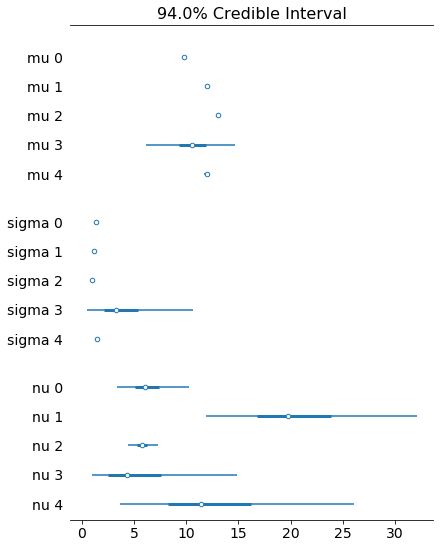

In [105]:
az.plot_forest(trace_htt, var_names = ['mu', 'sigma', 'nu'], combined = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff571587b8>,
      dtype=object)

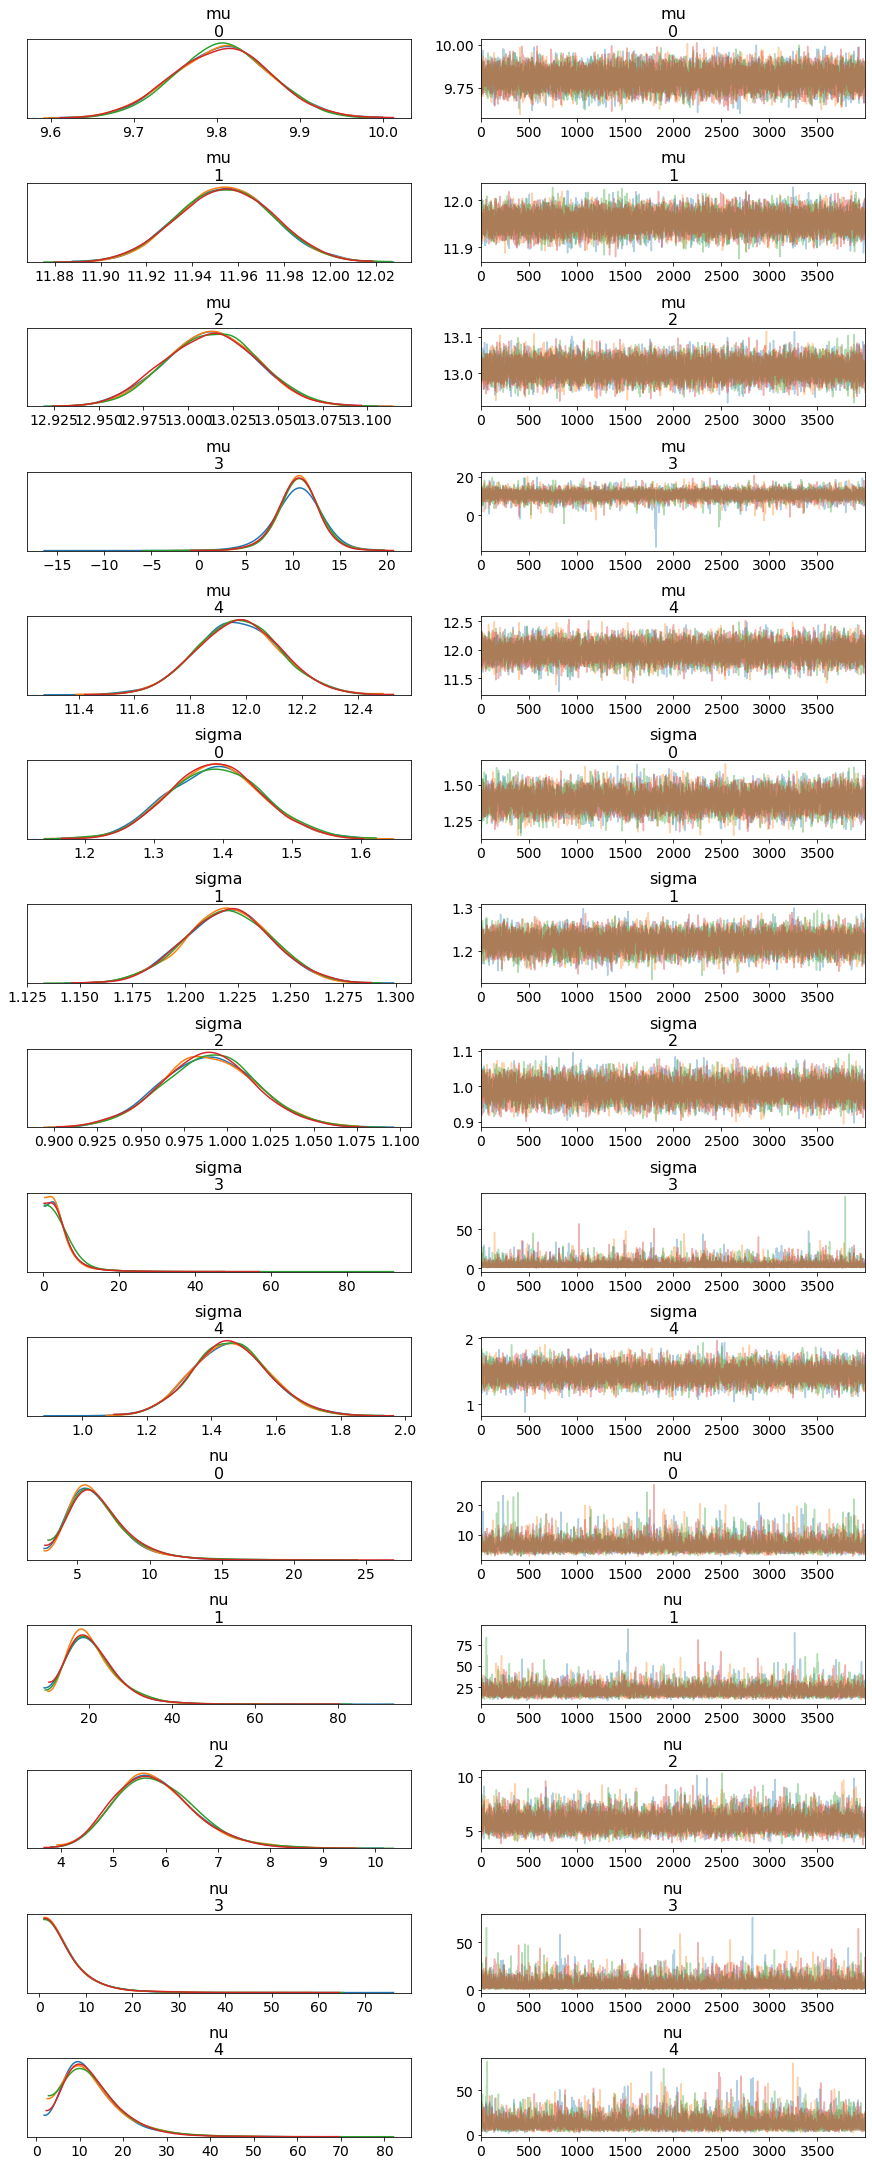

In [106]:
az.plot_trace(trace_htt, var_names = ['mu', 'sigma', 'nu'])

## Step 3: Use more informative priors to incorporate subject matter expertise

Suppose that the risk experts have strong beliefs that the company's risk exposures do not have a heavy tail.  The last product shows a heavy tail because the history of data collection is too short.  As time goes by, the losses should distributed more "normally."

We can incorporate this belief into our model through more informative priors.  We use a Gamma prior with a large mean and a small variance.

In [107]:
with pm.Model() as hier_model_tt:
    
    # hyper priors
    theta = pm.Normal('theta', mu = data_mean, sd = (data_max - data_min)/2.0)
    tau = pm.InverseGamma('tau', 2.0, 10.0)
    
    h = pm.InverseGamma('h', 2.0, 10.0)   

    delta = pm.Gamma('delta', 200.0, 10.0)

    # priors
    # degree of freedom
    # shifted exponential
    v_ = pm.Exponential('v_', 1.0/delta, shape = len(np.unique(group_ix)))
    nu = pm.Deterministic('nu', v_ + 1)
    
    #location
    mu = pm.Normal('mu', mu = theta, sd = tau, shape = len(np.unique(group_ix)))
    
    # scale
    s_ = pm.HalfNormal('s_', sd = h, shape = len(np.unique(group_ix)))
    sigma = pm.Deterministic('sigma', s_/nu) # reparametrize scale based on Gelman's recommendation
    
    # likelihood
    for i in np.unique(group_ix):
        trunc = pm.Bound(pm.StudentT, upper = np.log(5000))('trunc%s'%i, mu=mu[i], sigma=sigma[i], nu = nu[i],shape = n_group_censored[i])
        y = pm.StudentT('y%s'%i, mu = mu[i], sigma = sigma[i], nu = nu[i], observed = np.log(group_data[i]), shape = n_group_observed[i])

    trace_prior = pm.sample(4000, tune = 2500, cores = 2, chains = 4, random_seed = 42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [trunc4, trunc3, trunc2, trunc1, trunc0, s_, mu, v_, delta, h, tau, theta]
Sampling 4 chains: 100%|██████████| 26000/26000 [25:49<00:00, 16.77draws/s]


In [108]:
az.summary(trace_prior, var_names = ['mu', 'sigma', 'nu'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],9.807,0.057,9.701,9.915,0.000,0.000,15887.0,15887.0,15889.0,12015.0,1.0
mu[1],11.954,0.020,11.918,11.993,0.000,0.000,21342.0,21338.0,21355.0,11965.0,1.0
mu[2],13.013,0.025,12.967,13.062,0.000,0.000,20570.0,20570.0,20521.0,11820.0,1.0
mu[3],10.519,2.210,6.080,14.591,0.024,0.017,8342.0,8209.0,9397.0,8249.0,1.0
mu[4],11.973,0.147,11.697,12.252,0.001,0.001,19244.0,19244.0,19252.0,11447.0,1.0
sigma[0],1.394,0.068,1.267,1.523,0.001,0.000,10213.0,10092.0,10265.0,11236.0,1.0
sigma[1],1.224,0.020,1.187,1.264,0.000,0.000,8578.0,8546.0,8525.0,9518.0,1.0
sigma[2],0.990,0.027,0.939,1.041,0.000,0.000,11562.0,11524.0,11588.0,11400.0,1.0
sigma[3],4.331,3.737,0.683,10.516,0.037,0.026,10066.0,10066.0,11907.0,11896.0,1.0
sigma[4],1.473,0.116,1.265,1.701,0.001,0.001,11713.0,11465.0,11963.0,10552.0,1.0


## Alternative Methodologies

Alternatively, we can build a model without hyper-priors.  However, this model does not benefit from sharing the information acorss different segments.  The result is that non-identifiability of the risk cells with few loss events as shown in the following results where the posteriors for Group 3 have large variances.

### Group Model: Truncated Student's T

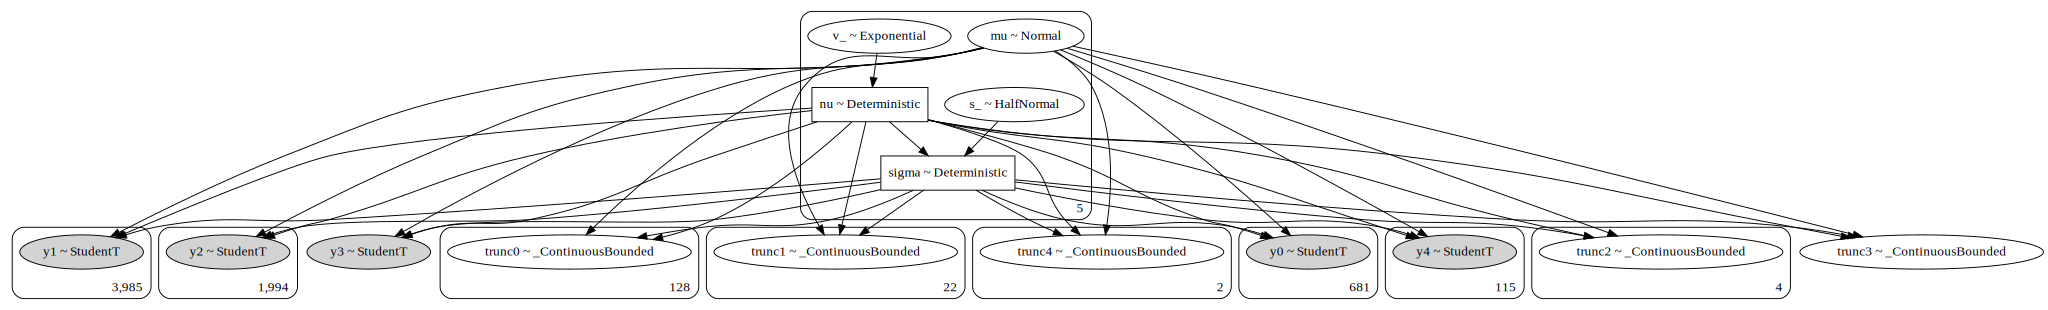

In [109]:
with pm.Model() as group_model_tt:
    
    # priors
    # degree of freedom
    # shifted exponential
    v_ = pm.Exponential('v_', 1.0/30.0, shape = len(np.unique(group_ix)))
    nu = pm.Deterministic('nu', v_ + 1)
    
    #location
    mu = pm.Normal('mu', mu = data_mean, sd = 10, shape = len(np.unique(group_ix)))
    
    # scale
    s_ = pm.HalfNormal('s_', sd = 10, shape = len(np.unique(group_ix)))
    sigma = pm.Deterministic('sigma', s_/nu) # reparametrize scale based on Gelman's recommendation
    
    # likelihood
    for i in np.unique(group_ix):
        trunc = pm.Bound(pm.StudentT, upper = np.log(5000))('trunc%s'%i, mu=mu[i], sigma=sigma[i], nu = nu[i],shape = n_group_censored[i])
        y = pm.StudentT('y%s'%i, mu = mu[i], sigma = sigma[i], nu = nu[i], observed = np.log(group_data[i]), shape = n_group_observed[i])

pm.model_to_graphviz(group_model_tt)  

In [110]:
with group_model_tt:
  trace_gtt = pm.sample(4000, tune = 2500, cores = 2, chains = 4, random_seed = 42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [trunc4, trunc3, trunc2, trunc1, trunc0, s_, mu, v_]
Sampling 4 chains: 100%|██████████| 26000/26000 [16:31<00:00, 20.19draws/s]


(<Figure size 432x540 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7eff75b7db70>],
       dtype=object))

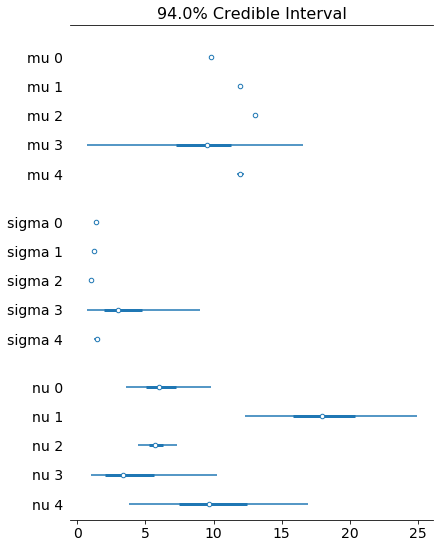

In [111]:
az.plot_forest(trace_gtt, var_names = ['mu', 'sigma', 'nu'], combined = True)

### Hierarchical Model: Truncated Normal

In the last example, we demonstrate a limitation of naively using a normal distribution for the log losses.  The issue is that the extreme losses carry too much influence on the parameters.  In particular, the scale estmate for the last product is 1.8 while the true value is 1.2.  This difference causes the 99.5th percentile of the estimated loss distribution to increase by 369%.

In [0]:
n_group_observed = [sum(group_ix == i) for i in np.unique(group_ix)]
p_censored = [stats.norm.cdf(np.log(5000), loc = m, scale = s,) for m, s in zip(
    group_mean, 
    group_sd, 
)]
n_group_censored = [int(np.ceil(n/(1 - p) * p)) for n, p in zip(n_group_observed, p_censored)]

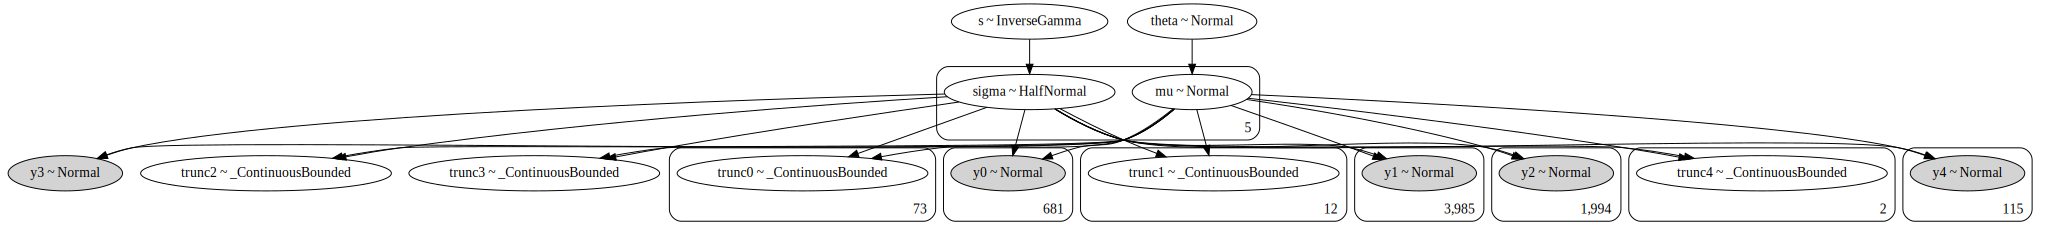

In [113]:
with pm.Model() as hier_model_tn:
    
    # hyper priors
    theta = pm.Normal('theta', mu = data_mean, sd = 10.0)
    s = pm.InverseGamma('s', 2.0, 10.0)
    
    # priors
    mu = pm.Normal('mu', mu = theta, sd = 10, shape = len(np.unique(group_ix)))
    sigma = pm.HalfNormal('sigma', sd = s, shape = len(np.unique(group_ix)))
    for i in np.unique(group_ix):
        trunc = pm.Bound(pm.Normal, upper = np.log(5000))('trunc%s'%i, mu=mu[i], sigma=sigma[i], shape = n_group_censored[i])
        y = pm.Normal('y%s'%i, mu = mu[i], sigma = sigma[i], observed = np.log(group_data[i]), shape = n_group_observed[i])

pm.model_to_graphviz(hier_model_tn)  

In [114]:
with hier_model_tn:
    trace_htn = pm.sample(4000, tune = 2500, chains = 4, cores = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [trunc4, trunc3, trunc2, trunc1, trunc0, sigma, mu, s, theta]
Sampling 4 chains: 100%|██████████| 26000/26000 [03:05<00:00, 140.20draws/s]


In [115]:
az.summary(trace_htn, var_names = ['mu', 'sigma'],)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],10.061,0.056,9.959,10.171,0.000,0.000,23492.0,23492.0,23446.0,11711.0,1.0
mu[1],11.964,0.020,11.926,12.002,0.000,0.000,17715.0,17715.0,17722.0,11751.0,1.0
mu[2],13.035,0.027,12.984,13.086,0.000,0.000,24648.0,24648.0,24666.0,11817.0,1.0
mu[3],8.903,3.356,2.222,14.936,0.040,0.029,7111.0,6597.0,8546.0,7056.0,1.0
mu[4],11.979,0.148,11.694,12.251,0.001,0.001,24441.0,24441.0,24445.0,11386.0,1.0
sigma[0],1.534,0.043,1.455,1.617,0.000,0.000,20907.0,20907.0,20862.0,11423.0,1.0
sigma[1],1.270,0.014,1.244,1.297,0.000,0.000,17822.0,17822.0,17835.0,11325.0,1.0
sigma[2],1.203,0.019,1.169,1.240,0.000,0.000,23748.0,23692.0,23834.0,12209.0,1.0
sigma[3],4.030,2.237,1.058,7.966,0.026,0.019,7388.0,7230.0,8657.0,8849.0,1.0
sigma[4],1.592,0.106,1.397,1.793,0.001,0.001,20535.0,20062.0,20972.0,11621.0,1.0
